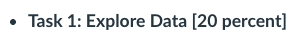

## Install necessary libraries



In [1]:
! pip install gseapy statsmodels scikit-learn matplotlib seaborn scipy pandas numpy -q 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy import stats
from statsmodels.stats.multitest import multipletests # Corrects p-values so DEG list is trustworthy

import os
os.makedirs("results", exist_ok=True)

# Gene set enrichment analysis
import gseapy as gp

# for DEG analysis
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)




/Users/nikc/Library/Python/3.14/lib/python/site-packages/google_crc32c/__init__.py:29: RuntimeWarning: As the c extension couldn't be imported, `google-crc32c` is using a pure python implementation that is significantly slower. If possible, please configure a c build environment and compile the extension
  warnings.warn(_SLOW_CRC32C_WARNING, RuntimeWarning)


## Read counts and class data

In [2]:
# counts data
counts = pd.read_csv("tcga_blca_v2_exp_count .csv.gz", compression="gzip", index_col=0)
print(counts.info())
gene_annotations = counts.iloc[:,0:3]
print("\n",gene_annotations.head())


<class 'pandas.core.frame.DataFrame'>
Index: 60660 entries, ENSG00000000003.15 to ENSG00000288675.1
Data columns (total 93 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   gene_type                     60660 non-null  object
 1   gene_name                     60660 non-null  object
 2   hgnc_id                       39014 non-null  object
 3   TCGA-4Z-AA7N-01A-11R-A39I-07  60660 non-null  int64 
 4   TCGA-K4-A54R-01A-11R-A26T-07  60660 non-null  int64 
 5   TCGA-DK-A1A3-01A-11R-A13Y-07  60660 non-null  int64 
 6   TCGA-BL-A0C8-01A-11R-A10U-07  60660 non-null  int64 
 7   TCGA-UY-A9PD-01A-11R-A38B-07  60660 non-null  int64 
 8   TCGA-4Z-AA87-01A-11R-A39I-07  60660 non-null  int64 
 9   TCGA-C4-A0F6-01A-11R-A10U-07  60660 non-null  int64 
 10  TCGA-BT-A20W-01A-21R-A14Y-07  60660 non-null  int64 
 11  TCGA-DK-A3IQ-01A-31R-A32Y-07  60660 non-null  int64 
 12  TCGA-SY-A9G0-01A-12R-A38B-07  60660 non-null  int6

In [3]:
# class data
cls = pd.read_csv("tcga_blca_v2_class.csv")
cls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   barcode     90 non-null     object
 1   patient     90 non-null     object
 2   tumor_type  90 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB


In [4]:
cls

,barcode,patient,tumor_type
0,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-4Z-AA7N,Low Grade
1,TCGA-K4-A54R-01A-11R-A26T-07,TCGA-K4-A54R,Low Grade
2,TCGA-DK-A1A3-01A-11R-A13Y-07,TCGA-DK-A1A3,Low Grade
3,TCGA-BL-A0C8-01A-11R-A10U-07,TCGA-BL-A0C8,Low Grade
4,TCGA-UY-A9PD-01A-11R-A38B-07,TCGA-UY-A9PD,Low Grade
...,...,...,...
85,TCGA-GD-A3OQ-01A-32R-A220-07,TCGA-GD-A3OQ,High Grade
86,TCGA-CU-A72E-01A-12R-A33J-07,TCGA-CU-A72E,High Grade
87,TCGA-DK-A1AB-01A-11R-A13Y-07,TCGA-DK-A1AB,High Grade
88,TCGA-FD-A3B7-01A-31R-A20F-07,TCGA-FD-A3B7,High Grade


In [5]:
counts.shape, cls.shape

((60660, 93), (90, 3))

In [6]:
# Align sample order
# Keep only columns whose names appear in cls["barcode"]

counts = counts[cls["barcode"].values]
print(counts.shape)

(60660, 90)


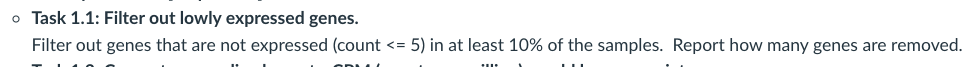

In [7]:
# If a gene has 9 or more samples where the expression ≤ 5 → REMOVE that gene
n_samples = counts.shape[1]
threshold = 0.10 * n_samples   # 10% of 90 samples = 9  

# Count how many samples have counts ≤ 5 for each gene
low_expr_counts = (counts <= 5).sum(axis=1) # counts how many samples (columns) have count ≤ 5 for each gene

# Remove genes where low expression happens in ≥10% samples
remove_mask = low_expr_counts >= threshold # gene with true boolean value  becomes false at nest step and get removed.
print(remove_mask)

keep_mask = ~remove_mask # inverted it using keep_mask to keep high quality gene
print("\n", keep_mask)

filtered_counts = counts.loc[keep_mask] # filtering

# Reporting
removed_genes = remove_mask.sum()
remaining_genes = keep_mask.sum()

print("\n Total genes:", counts.shape[0])
print("Genes removed:", removed_genes)
print("Genes remaining:", remaining_genes)

gene_id
ENSG00000000003.15    False
ENSG00000000005.6      True
ENSG00000000419.13    False
ENSG00000000457.14    False
ENSG00000000460.17    False
                      ...  
ENSG00000288669.1      True
ENSG00000288670.1     False
ENSG00000288671.1      True
ENSG00000288674.1      True
ENSG00000288675.1     False
Length: 60660, dtype: bool

 gene_id
ENSG00000000003.15     True
ENSG00000000005.6     False
ENSG00000000419.13     True
ENSG00000000457.14     True
ENSG00000000460.17     True
                      ...  
ENSG00000288669.1     False
ENSG00000288670.1      True
ENSG00000288671.1     False
ENSG00000288674.1     False
ENSG00000288675.1      True
Length: 60660, dtype: bool

 Total genes: 60660
Genes removed: 44693
Genes remaining: 15967


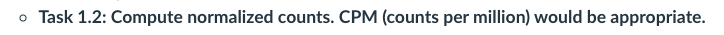

In [8]:
filtered_counts

,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-K4-A54R-01A-11R-A26T-07,TCGA-DK-A1A3-01A-11R-A13Y-07,TCGA-BL-A0C8-01A-11R-A10U-07,TCGA-UY-A9PD-01A-11R-A38B-07,TCGA-4Z-AA87-01A-11R-A39I-07,TCGA-C4-A0F6-01A-11R-A10U-07,TCGA-BT-A20W-01A-21R-A14Y-07,TCGA-DK-A3IQ-01A-31R-A32Y-07,TCGA-SY-A9G0-01A-12R-A38B-07,...,TCGA-XF-A8HE-01A-11R-A36F-07,TCGA-ZF-A9RD-01A-11R-A42T-07,TCGA-E7-A7XN-01A-11R-A352-07,TCGA-PQ-A6FN-01A-11R-A31N-07,TCGA-BT-A3PK-01A-21R-A220-07,TCGA-GD-A3OQ-01A-32R-A220-07,TCGA-CU-A72E-01A-12R-A33J-07,TCGA-DK-A1AB-01A-11R-A13Y-07,TCGA-FD-A3B7-01A-31R-A20F-07,TCGA-FD-A6TH-01A-11R-A32O-07
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,2536,2166,4828,24591,4110,10250,6161,4801,2245,1717,...,1027,1305,1311,3573,4324,8491,5222,2766,1888,959
ENSG00000000419.13,1096,2256,1494,1283,1637,2624,1676,1959,1220,1525,...,1458,1792,1425,2395,4134,2430,1760,2160,3244,3775
ENSG00000000457.14,279,334,565,608,434,1041,425,365,459,444,...,626,217,570,235,987,1395,596,1143,586,785
ENSG00000000460.17,163,357,468,557,571,2557,520,434,148,261,...,546,257,390,350,978,852,353,596,786,1272
ENSG00000000938.13,420,485,260,129,73,315,106,252,225,238,...,934,214,342,305,1357,290,406,615,1010,411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288596.2,75,69,36,113,59,92,78,203,83,134,...,75,49,46,102,80,62,156,140,78,177
ENSG00000288612.1,22,6,7,25,29,27,3,34,18,23,...,30,8,35,16,34,16,9,12,8,31
ENSG00000288663.1,13,30,6,17,19,32,5,34,25,19,...,10,10,13,11,25,16,28,12,9,27


In [9]:
# 1) Library size = total counts per sample
library_sizes = filtered_counts.sum(axis=0) # sum rows for each sample i.e total count for that sample

# 2) Compute CPM
cpm = filtered_counts.divide(library_sizes, axis=1) * 1e6 # axis=1 means "divide across columns"

# 3) log-transform (recommended for PCA, clustering)
logcpm = np.log2(cpm + 1)

print("Library sizes:\n", library_sizes)
print("\nCPM matrix shape:", cpm.shape)
print("\nlogCPM matrix shape:", logcpm.shape)

Library sizes:
 TCGA-4Z-AA7N-01A-11R-A39I-07    23681428
TCGA-K4-A54R-01A-11R-A26T-07    34970840
TCGA-DK-A1A3-01A-11R-A13Y-07    40636024
TCGA-BL-A0C8-01A-11R-A10U-07    37103901
TCGA-UY-A9PD-01A-11R-A38B-07    28697214
                                  ...   
TCGA-GD-A3OQ-01A-32R-A220-07    63292271
TCGA-CU-A72E-01A-12R-A33J-07    58594055
TCGA-DK-A1AB-01A-11R-A13Y-07    71765220
TCGA-FD-A3B7-01A-31R-A20F-07    59585358
TCGA-FD-A6TH-01A-11R-A32O-07    66603518
Length: 90, dtype: int64

CPM matrix shape: (15967, 90)

logCPM matrix shape: (15967, 90)


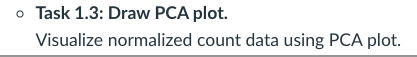

In [10]:
# X = samples × genes
X = logcpm.T

# Standardize
# CPM + log2 transform normalizes expression values across samples
# StandardScaler() normalizes features (genes in our case)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Scaled data for PCA and clustering

# Fit PCA using all components
pca = PCA()
pcs = pca.fit_transform(X_scaled)  # samples × PCs
var_explained = pca.explained_variance_ratio_ * 100

explained_var = pca.explained_variance_ratio_

# Compute cumulative variance
cumulative = explained_var.cumsum()

# Find number of PCs needed for < 75% variance
threshold = 0.75  # 75%
n_pcs_75 = np.argmax(cumulative >= threshold)  # first PC index that reaches 75%

print(f"Total PCs: {len(explained_var)}")
print(f"PCs needed to reach 75% variance: {n_pcs_75}")

print("\nFirst 10 explained variances:")
print(explained_var[:10])

print("\nFirst 30 cumulative variances:")
print(cumulative[:31])

Total PCs: 90
PCs needed to reach 75% variance: 30

First 10 explained variances:
[0.1354703  0.09306911 0.07364748 0.04236215 0.0373411  0.03436416
 0.03006957 0.02596715 0.02398247 0.02086394]

First 30 cumulative variances:
[0.1354703  0.22853941 0.30218689 0.34454904 0.38189014 0.41625431
 0.44632387 0.47229102 0.49627349 0.51713743 0.5357878  0.55185892
 0.56713067 0.5814727  0.59504091 0.60811435 0.62073229 0.63297375
 0.6449866  0.65611474 0.66675411 0.6771002  0.68723679 0.69692062
 0.70638077 0.71546375 0.72424407 0.73274744 0.74107425 0.74907232
 0.75702043]


PCA shape: (90, 31)
PC1 variance:   13.547030356727275
PC2 variance:   9.306910651515356


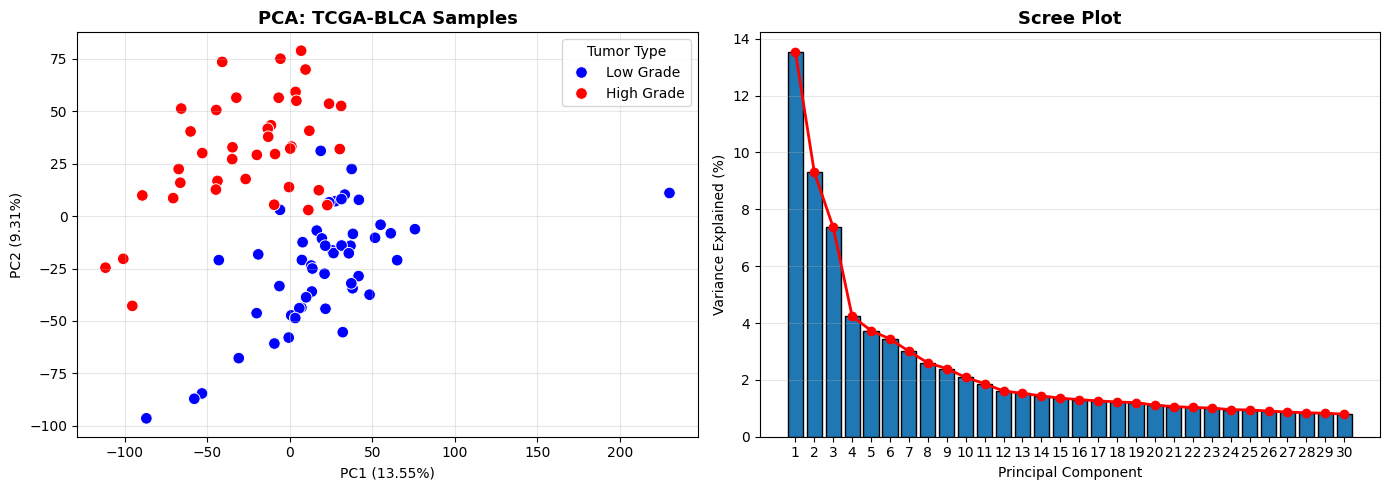

In [11]:
pca = PCA(n_components=30, random_state=0)
pcs = pca.fit_transform(X_scaled)          # shape: (90 samples, 10 PCs)
var_explained = pca.explained_variance_ratio_ * 100  # % variance

# Make a DataFrame for plotting PC1 vs PC2
pc_cols = [f"PC{i+1}" for i in range(30)]
pca_df = pd.DataFrame(pcs, columns=pc_cols)
pca_df["Class"] = cls["tumor_type"].values   # Low Grade / High Grade

# print(pca_df.head())
print("PCA shape:", pca_df.shape)
print("PC1 variance:  ", var_explained[0])
print("PC2 variance:  ", var_explained[1])

# -------------------------------------------------
# 3. Plot PCA scatter + Scree plot
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- (A) PCA scatter: PC1 vs PC2 coloured by tumor grade ----
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Class",
    palette={"Low Grade": "blue", "High Grade": "red"},
    s=70,
    ax=axes[0],
)

axes[0].set_title("PCA: TCGA-BLCA Samples", fontsize=13, fontweight="bold")
axes[0].set_xlabel(f"PC1 ({var_explained[0]:.2f}%)")
axes[0].set_ylabel(f"PC2 ({var_explained[1]:.2f}%)")
axes[0].grid(True, alpha=0.3)
axes[0].legend(title="Tumor Type")

# ---- (B) Scree plot: variance explained by each PC ----
pc_indices = range(1, len(var_explained) + 1)

axes[1].bar(pc_indices, var_explained, edgecolor="black")
axes[1].plot(pc_indices, var_explained, "o-", color="red", linewidth=2)

axes[1].set_title("Scree Plot", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Variance Explained (%)")
axes[1].set_xticks(pc_indices)
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("results/task1_pca_and_scree.png", dpi=300, bbox_inches="tight")
plt.show()

## Question 2
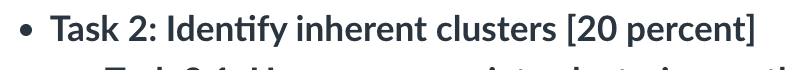

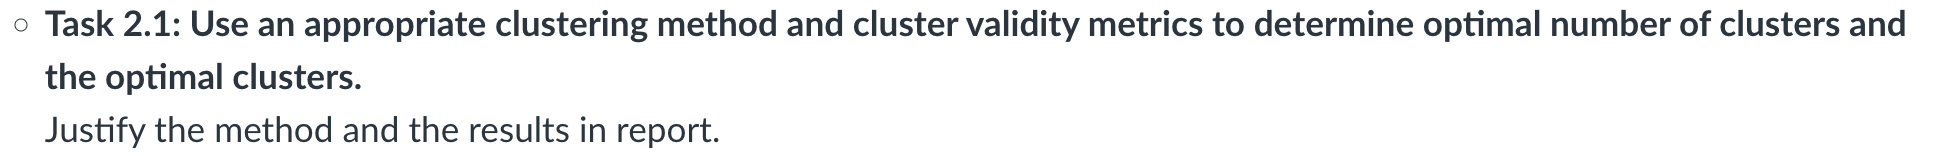

In [12]:
# We use  30-PC matrix from earlier
pc_for_cluster = pcs  # shape: samples × 30

ks = range(2, 9)

sil_kmeans = []
sil_single = []
sil_avg = []
sil_complete = []

In [13]:
for k in ks:
    
    # KMEANS 
    km = KMeans(n_clusters=k, n_init=50, random_state=0) # algorithm started from 50 different random initial centroid positions
    labels_km = km.fit_predict(X_scaled)
    sil_kmeans.append(silhouette_score(X_scaled, labels_km)) 
    
    # HIERARCHICAL (single)
    sing = AgglomerativeClustering(n_clusters=k, linkage="single")
    labels_single = sing.fit_predict(X_scaled)
    sil_single.append(silhouette_score(X_scaled, labels_single))
    
    # HIERARCHICAL (AVERAGE) 
    avg = AgglomerativeClustering(n_clusters=k, linkage="average")
    labels_avg = avg.fit_predict(X_scaled)
    sil_avg.append(silhouette_score(X_scaled, labels_avg))
    
    # HIERARCHICAL (COMPLETE) 
    comp = AgglomerativeClustering(n_clusters=k, linkage="complete")
    labels_comp = comp.fit_predict(X_scaled)
    sil_complete.append(silhouette_score(X_scaled, labels_comp))

### Create silhoutte table for all clustering method

In [14]:
# Combine into a table
sil_df = pd.DataFrame({
    "k": list(ks),
    "KMeans": sil_kmeans,
    "single": sil_single,
    "Average": sil_avg,
    "Complete": sil_complete
})

print("\nSilhouette Table (Higher = Better):\n")
print(sil_df)


Silhouette Table (Higher = Better):

   k    KMeans    single   Average  Complete
0  2  0.072425  0.435395  0.435395  0.435395
1  3  0.069850  0.197777  0.197777  0.104671
2  4  0.061661  0.148466  0.148466  0.095754
3  5  0.058564  0.066422  0.098384  0.091422
4  6  0.052884  0.046976  0.087558  0.085819
5  7  0.047115  0.046152  0.076962  0.057482
6  8  0.049607  0.044114  0.068630  0.054031


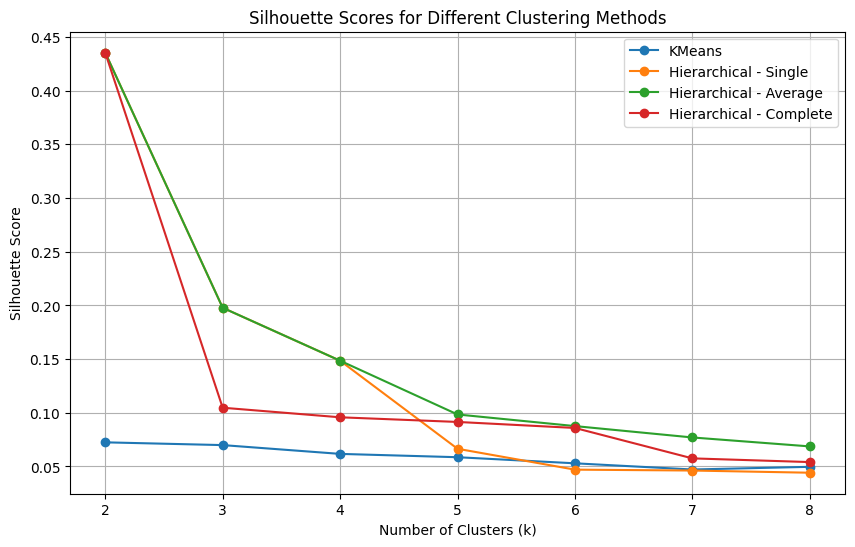

In [15]:
# PLOT SILHOUETTE VALUES
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(ks, sil_kmeans, marker='o', label="KMeans")
plt.plot(ks, sil_single, marker='o', label="Hierarchical - Single")
plt.plot(ks, sil_avg, marker='o', label="Hierarchical - Average")
plt.plot(ks, sil_complete, marker='o', label="Hierarchical - Complete")

plt.title("Silhouette Scores for Different Clustering Methods")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

### The highest silhouette score across all methods occurs at k = 2
	 •	Single linkage (k=2): 0.435
	 •	Average linkage (k=2): 0.435
	 •	Complete linkage (k=2): 0.435
### Hierarchical methods clearly outperform KMeans - This means Data does not form spherical/symmetric clusters. Hierarchical linkage methods capture structure better



# 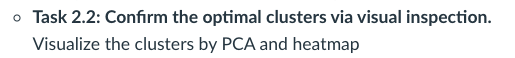

In [16]:
print(pca_df.head())


         PC1        PC2        PC3        PC4        PC5        PC6  \
0  41.704006 -28.606175  50.968979  30.786778 -20.283243 -14.230635   
1  -5.876051   2.952769  -7.565306 -11.736968  16.974955  -0.100358   
2  16.374700  -6.938034  17.091847 -56.939004  19.581623 -41.341530   
3  75.822118  -6.258516 -14.222641   7.634270 -21.756315 -26.073562   
4  13.411132 -35.974872 -56.684544 -12.276494  21.769948 -10.722613   

         PC7        PC8        PC9       PC10  ...       PC22       PC23  \
0  40.195649 -10.559212  28.269990   1.504052  ...  -0.412076  -4.709121   
1  12.981422  13.972131  16.179418  -6.558934  ... -12.177201   9.022977   
2   9.158836  30.209711 -21.840871 -12.629622  ... -12.273177  28.018999   
3 -44.270865  20.803980  -3.139500  40.541011  ... -20.519578  13.064216   
4  -6.905038  -9.355206   4.195553  -4.101076  ... -12.085352  -0.949357   

        PC24       PC25       PC26       PC27       PC28       PC29  \
0 -12.274589  -4.727411   1.780205  -5.149465

In [17]:
print(pca_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     90 non-null     float64
 1   PC2     90 non-null     float64
 2   PC3     90 non-null     float64
 3   PC4     90 non-null     float64
 4   PC5     90 non-null     float64
 5   PC6     90 non-null     float64
 6   PC7     90 non-null     float64
 7   PC8     90 non-null     float64
 8   PC9     90 non-null     float64
 9   PC10    90 non-null     float64
 10  PC11    90 non-null     float64
 11  PC12    90 non-null     float64
 12  PC13    90 non-null     float64
 13  PC14    90 non-null     float64
 14  PC15    90 non-null     float64
 15  PC16    90 non-null     float64
 16  PC17    90 non-null     float64
 17  PC18    90 non-null     float64
 18  PC19    90 non-null     float64
 19  PC20    90 non-null     float64
 20  PC21    90 non-null     float64
 21  PC22    90 non-null     float64
 22  PC23

In [18]:
# PCA Visualization - chosing average clustering method
# final chosen clustering method from Task 2.1
best_k = 2
# final_model = AgglomerativeClustering(n_clusters=best_k, linkage="average")
# final_labels = final_model.fit_predict(X_scaled)  

km = KMeans(n_clusters=best_k, n_init=50, random_state=0) # algorithm started from 50 different random initial centroid positions
final_labels = km.fit_predict(X_scaled)


# Add cluster labels to PC dataframe
pca_df["Cluster"] = final_labels
pca_df.head()
     

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,Class,Cluster
0,41.704006,-28.606175,50.968979,30.786778,-20.283243,-14.230635,40.195649,-10.559212,28.269990,1.504052,...,-4.709121,-12.274589,-4.727411,1.780205,-5.149465,7.699141,-0.490907,-4.249088,Low Grade,0
1,-5.876051,2.952769,-7.565306,-11.736968,16.974955,-0.100358,12.981422,13.972131,16.179418,-6.558934,...,9.022977,-36.587931,18.383443,-19.027657,12.571293,20.066300,-13.146111,-9.496013,Low Grade,0
2,16.374700,-6.938034,17.091847,-56.939004,19.581623,-41.341530,9.158836,30.209711,-21.840871,-12.629622,...,28.018999,9.048002,-11.037661,-23.534136,6.863213,8.841182,29.323509,10.386331,Low Grade,0
3,75.822118,-6.258516,-14.222641,7.634270,-21.756315,-26.073562,-44.270865,20.803980,-3.139500,40.541011,...,13.064216,-17.823445,-9.480348,2.950583,-1.392247,-7.966802,-8.367908,-0.854074,Low Grade,0
4,13.411132,-35.974872,-56.684544,-12.276494,21.769948,-10.722613,-6.905038,-9.355206,4.195553,-4.101076,...,-0.949357,6.447925,-13.199366,-33.876519,9.248884,24.266313,4.801458,26.977721,Low Grade,0


In [19]:
# n_zeros = (pca_df["Cluster"] == 0).sum()
# n_ones  = (pca_df["Cluster"] == 1).sum()
# print("Cluster 0:", n_zeros)
# print("Cluster 1:", n_ones)

In [20]:
pca_df.shape

(90, 32)

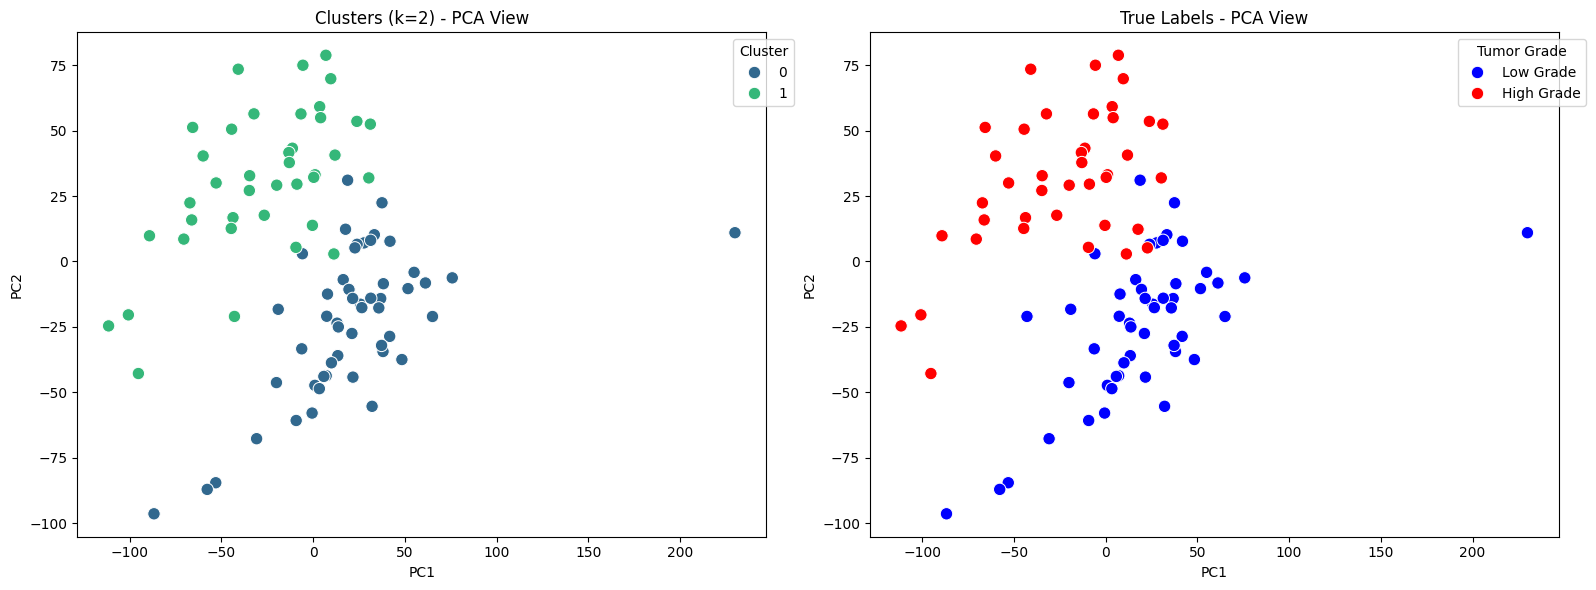

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- LEFT: PCA with clusters ----------
sns.scatterplot(
    ax=axes[0],
    data=pca_df,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="viridis",
    s=80
)
axes[0].set_title(f"Clusters (k={best_k}) - PCA View")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster", bbox_to_anchor=(1.05, 1))

# ---------- RIGHT: PCA with true labels ----------
sns.scatterplot(
    ax=axes[1],
    data=pca_df,
    x="PC1", y="PC2",
    hue="Class",
    palette={"Low Grade": "blue", "High Grade": "red"},
    s=80
)
axes[1].set_title("True Labels - PCA View")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend(title="Tumor Grade", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

### Even though hierarchical clustering showed higher silhouette score, K-means is the correct and meaningful choice because it produces biologically sensible clusters

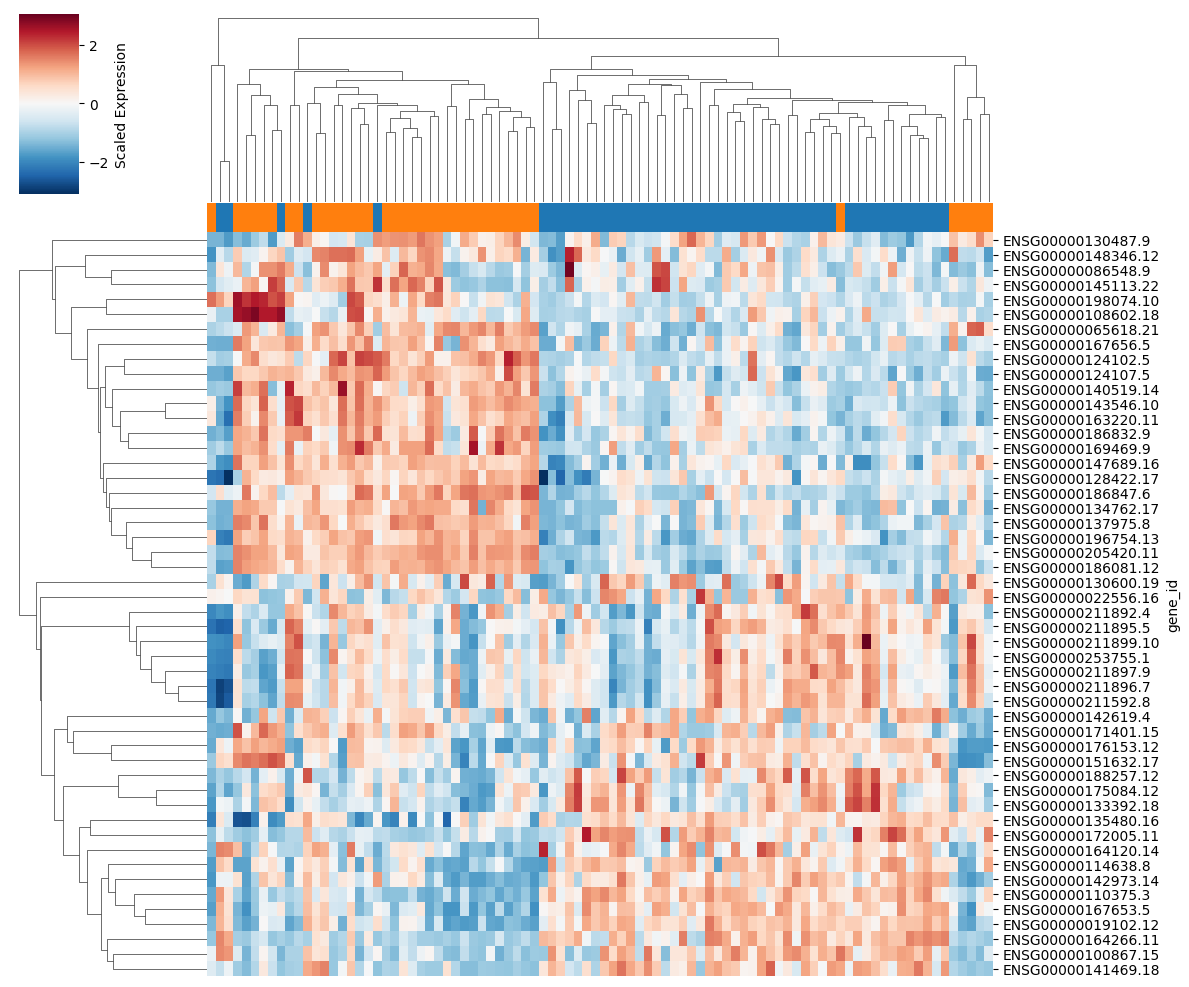

In [22]:
gene_variance = logcpm.var(axis=1) # logcpm: gene × sample; Genes with high variance are most useful for clustering visualization
top_genes = gene_variance.nlargest(50).index # Selects the 50 genes with the highest variance

heatmap_data = logcpm.loc[top_genes, :] # top 50 genes (rows) with all samples (columns)

# 2. Standardize expression for visualization (Z-score per gene) # axis=1 for every row
heatmap_data_scaled = (heatmap_data - heatmap_data.mean(axis=1).values.reshape(-1,1)) \
                      / heatmap_data.std(axis=1).values.reshape(-1,1)

# 3. Create cluster-color annotation
cluster_colors = [f"C{c}" for c in final_labels]   # final_labels comes from Task 2.1

# 4. Draw heatmap with hierarchical clustering
sns.clustermap(
    heatmap_data_scaled, 
    col_colors=cluster_colors,
    cmap="RdBu_r",  # Red-Blue colormap
    center=0,          # Colors are centered at 0 (Z-score), so red = positive, blue = negative
    cbar_kws={'label': 'Scaled Expression'}, # color bar label
    xticklabels=False,  # hide sample names (too many samples)
    yticklabels=True,   # show gene names
    figsize=(12, 10)
)

plt.savefig("task2_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

## Task 2.3: Cluster Entropy
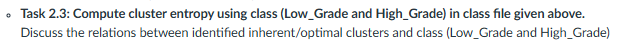

Cluster Entropy Results
Weighted Cluster Entropy: 0.2098
Max Entropy: 1.0000
Normalized Entropy: 0.2098

Cluster 0:
  Size: 51
  Entropy: 0.2387
  Composition: {'High Grade': np.int64(2), 'Low Grade': np.int64(49)}

Cluster 1:
  Size: 39
  Entropy: 0.1720
  Composition: {'High Grade': np.int64(38), 'Low Grade': np.int64(1)}


Confusion Matrix:
col_0  High Grade  Low Grade
row_0                       
0               2         49
1              38          1


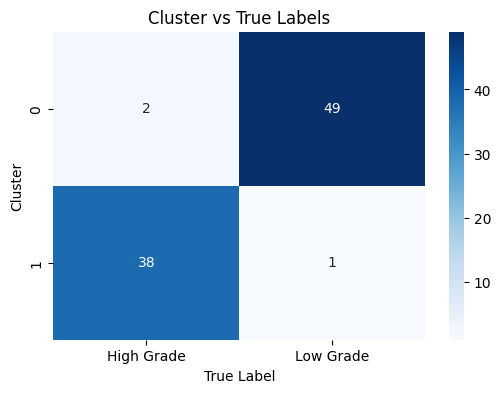

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# YOUR VARIABLES
cluster_assignments = np.array(final_labels)         # from Task 2.1
sample_labels      = np.array(cls["tumor_type"])     # your class labels (Low_Grade / High_Grade)

def compute_entropy(cluster_assignments, true_labels):
    clusters = np.unique(cluster_assignments)
    total_entropy = 0
    n_samples = len(cluster_assignments)

    cluster_stats = []

    for cluster in clusters:
        mask = cluster_assignments == cluster
        cluster_labels = true_labels[mask]

        unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
        proportions = label_counts / label_counts.sum()

        # entropy
        cluster_entropy = -np.sum(proportions * np.log2(proportions + 1e-10))

        # weighted entropy
        cluster_weight = mask.sum() / n_samples
        total_entropy += cluster_weight * cluster_entropy

        cluster_stats.append({
            "Cluster": cluster,
            "Size": mask.sum(),
            "Entropy": cluster_entropy,
            "Composition": dict(zip(unique_labels, label_counts))
        })

    return total_entropy, cluster_stats



# Run entropy

weighted_entropy, cluster_info = compute_entropy(cluster_assignments, sample_labels)

max_entropy = np.log2(len(np.unique(sample_labels)))

print("Cluster Entropy Results")
print("="*60)
print(f"Weighted Cluster Entropy: {weighted_entropy:.4f}")
print(f"Max Entropy: {max_entropy:.4f}")
print(f"Normalized Entropy: {weighted_entropy/max_entropy:.4f}\n")

for info in cluster_info:
    print(f"Cluster {info['Cluster']}:")
    print(f"  Size: {info['Size']}")
    print(f"  Entropy: {info['Entropy']:.4f}")
    print(f"  Composition: {info['Composition']}")
    print()

# Confusion matrix
confusion = pd.crosstab(cluster_assignments, sample_labels)
print("\nConfusion Matrix:")
print(confusion)

plt.figure(figsize=(6,4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs True Labels")
plt.xlabel("True Label")
plt.ylabel("Cluster")
plt.show()


### The main cluster (Cluster 0) contains a  Contained 49/51 samples, (mostly low grade, pure cluster).
### Cluster 1 : 38 High Grade, 1 Low grade 
### Low entropy confirms high purity clusters.
### Unsupervised clustering cleanly separates tumor grade with ~97% accuracy and low entropy, indicating two biologically coherent groups (Low Grade in Cluster 0, High Grade in Cluster 1).

# Question 3


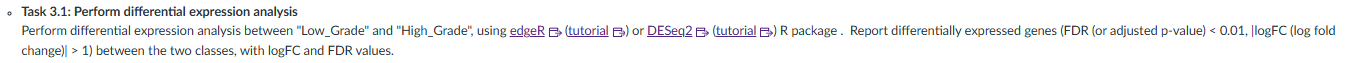

In [24]:
#print(counts.head())
counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60660 entries, ENSG00000000003.15 to ENSG00000288675.1
Data columns (total 90 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   TCGA-4Z-AA7N-01A-11R-A39I-07  60660 non-null  int64
 1   TCGA-K4-A54R-01A-11R-A26T-07  60660 non-null  int64
 2   TCGA-DK-A1A3-01A-11R-A13Y-07  60660 non-null  int64
 3   TCGA-BL-A0C8-01A-11R-A10U-07  60660 non-null  int64
 4   TCGA-UY-A9PD-01A-11R-A38B-07  60660 non-null  int64
 5   TCGA-4Z-AA87-01A-11R-A39I-07  60660 non-null  int64
 6   TCGA-C4-A0F6-01A-11R-A10U-07  60660 non-null  int64
 7   TCGA-BT-A20W-01A-21R-A14Y-07  60660 non-null  int64
 8   TCGA-DK-A3IQ-01A-31R-A32Y-07  60660 non-null  int64
 9   TCGA-SY-A9G0-01A-12R-A38B-07  60660 non-null  int64
 10  TCGA-XF-AAMY-01A-11R-A42T-07  60660 non-null  int64
 11  TCGA-DK-A1A7-01A-11R-A13Y-07  60660 non-null  int64
 12  TCGA-DK-A3IL-01A-11R-A20F-07  60660 non-null  int64
 13  TCGA-FD

In [25]:
#   Load metadata (class = HighGrade/ LowGrade) & convert column class into category
# print(cls.head)
metadata = pd.read_csv("tcga_blca_v2_class.csv", index_col=0)
metadata["tumor_type"] = metadata["tumor_type"].astype("category")
print(metadata.info())

# taking filtered data 
filtered_counts.shape

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, TCGA-4Z-AA7N-01A-11R-A39I-07 to TCGA-FD-A6TH-01A-11R-A32O-07
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   patient     90 non-null     object  
 1   tumor_type  90 non-null     category
dtypes: category(1), object(1)
memory usage: 1.6+ KB
None


(15967, 90)

In [26]:
# Transpose for PyDESeq2 (samples as rows)
counts_t = filtered_counts.T
print(counts_t.shape)

(90, 15967)


In [27]:
# Reorder metadata to match count samples
metadata = metadata.loc[counts_t.index]
print(metadata.shape)
metadata.index

(90, 2)


Index(['TCGA-4Z-AA7N-01A-11R-A39I-07', 'TCGA-K4-A54R-01A-11R-A26T-07',
       'TCGA-DK-A1A3-01A-11R-A13Y-07', 'TCGA-BL-A0C8-01A-11R-A10U-07',
       'TCGA-UY-A9PD-01A-11R-A38B-07', 'TCGA-4Z-AA87-01A-11R-A39I-07',
       'TCGA-C4-A0F6-01A-11R-A10U-07', 'TCGA-BT-A20W-01A-21R-A14Y-07',
       'TCGA-DK-A3IQ-01A-31R-A32Y-07', 'TCGA-SY-A9G0-01A-12R-A38B-07',
       'TCGA-XF-AAMY-01A-11R-A42T-07', 'TCGA-DK-A1A7-01A-11R-A13Y-07',
       'TCGA-DK-A3IL-01A-11R-A20F-07', 'TCGA-FD-A3SR-01A-11R-A22U-07',
       'TCGA-GU-AATP-01A-11R-A39I-07', 'TCGA-CU-A0YO-01A-11R-A10U-07',
       'TCGA-KQ-A41S-01A-12R-A33J-07', 'TCGA-FD-A43S-01A-21R-A23W-07',
       'TCGA-XF-A9SV-01A-21R-A42T-07', 'TCGA-DK-A3IK-01A-32R-A21D-07',
       'TCGA-GU-A767-01A-11R-A32O-07', 'TCGA-XF-A9SK-01A-11R-A42T-07',
       'TCGA-BL-A0C8-01B-04R-A277-07', 'TCGA-DK-A1A6-01A-11R-A13Y-07',
       'TCGA-K4-A83P-01A-11R-A352-07', 'TCGA-E7-A85H-01A-11R-A352-07',
       'TCGA-XF-A9SL-01A-11R-A39I-07', 'TCGA-K4-A6MB-01A-11R-A31N-07',
      

In [28]:
# DeseqDataSet(...) Loads your data into a DESeq2 object & sets your experimental design
# dds.deseq2() runs the full DESeq2 pipeline, which includes Normalizes counts, Estimates dispersion, Fits model, Shrinks LFC / dispersion, Computes p-values, FDR

# prepares the data.
dds = DeseqDataSet(
    counts=counts_t, # filtered + transpose one
    metadata=metadata,
    design_factors="tumor_type"
)

dds.deseq2()



Using None as control genes, passed at DeseqDataSet initialization


/var/folders/gp/j3rnm9qn6pzf3bwygfrrd5cm0000gq/T/ipykernel_18351/87338907.py:5: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 0.64 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 0.71 seconds.

Fitting LFCs...
... done in 0.39 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 537 outlier genes.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.03 seconds.



In [29]:
# Extracts statistical test results
dds_stats = DeseqStats(
    dds,
    contrast=["tumor_type", "Low Grade", "High Grade"]
)

dds_stats.summary() # Returns a formatted, human-readable text summary.

Running Wald tests...


Log2 fold change & Wald test p-value: tumor_type Low Grade vs High Grade
                       baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                               
ENSG00000000003.15  5301.552134        1.306550  0.186212  7.016470   
ENSG00000000419.13  2138.942899       -0.154974  0.111737 -1.386954   
ENSG00000000457.14   611.539781        0.523953  0.136736  3.831852   
ENSG00000000460.17   566.039811        0.348056  0.207569  1.676825   
ENSG00000000938.13   513.749925       -0.422075  0.219126 -1.926180   
...                         ...             ...       ...       ...   
ENSG00000288596.2    129.602067        0.521716  0.153116  3.407321   
ENSG00000288612.1     26.396189        0.084982  0.214633  0.395941   
ENSG00000288663.1     23.201846        0.858258  0.173111  4.957837   
ENSG00000288670.1    249.401701        0.530171  0.189165  2.802684   
ENSG00000288675.1     28.643187       -0.208631  0.198684 -1.050068   

   

... done in 0.27 seconds.



In [30]:

# Apply FDR cutoff < 0.01
# FDR = False Discovery Rate
# gene’s adjusted p-value (FDR) < 0.01
# we expect at most 1% to be false positives & it gives high confidence that the genes we’re calling significant are real differences and not noise.
res = dds_stats.results_df #results as a structured pandas DataFrame
# print(res.head())

deg_filtered= res[(res["padj"] < 0.01) & (res["log2FoldChange"].abs() > 1)]
deg_filtered= deg_filtered.sort_values("padj")

print(deg_filtered.shape)

print("Number of DEGs (FDR < 0.01):", deg_filtered.shape[0])
deg_filtered.head()



(2146, 6)
Number of DEGs (FDR < 0.01): 2146


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSG00000267280.5,376.695515,4.272548,0.284260,15.030421,4.640502e-51,7.409489e-47
ENSG00000121068.14,4290.625532,3.560445,0.237617,14.983980,9.344855e-51,7.460465e-47
ENSG00000092295.12,1257.145068,-5.031445,0.337547,-14.905919,3.016325e-50,1.605389e-46
ENSG00000021355.13,8455.120634,-2.665121,0.179868,-14.817105,1.135741e-49,4.533594e-46
ENSG00000164086.10,3871.779565,-2.431404,0.176016,-13.813516,2.112625e-43,6.746456e-40


### 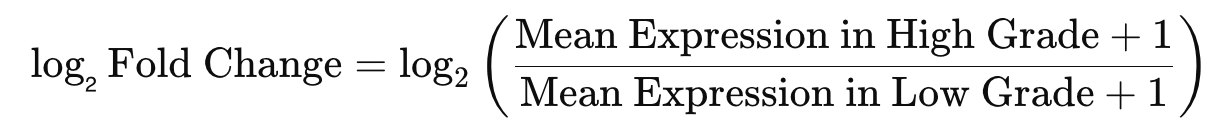

In [31]:
# Report summary counts
print("Total genes analyzed:", res.shape[0])
print("Significant DEGs (FDR < 0.01 & |log2FC| > 1):", deg_filtered.shape[0])
print("Upregulated:", (deg_filtered["log2FoldChange"] > 1).sum())
print("Downregulated:", (deg_filtered["log2FoldChange"] < -1).sum())


Total genes analyzed: 15967
Significant DEGs (FDR < 0.01 & |log2FC| > 1): 2146
Upregulated: 1346
Downregulated: 800


In [32]:
# Print Top 10 Up & Down Genes
print("\nTop 10 Upregulated Genes:")
print(deg_filtered.sort_values("log2FoldChange", ascending=False).head(10)[
    ["log2FoldChange", "padj"]
])

print("\nTop 10 Downregulated Genes:")
print(deg_filtered.sort_values("log2FoldChange", ascending=True).head(10)[
    ["log2FoldChange", "padj"]
])



Top 10 Upregulated Genes:
                    log2FoldChange          padj
gene_id                                         
ENSG00000164266.11        5.549721  6.042572e-24
ENSG00000100867.15        5.147262  1.964044e-27
ENSG00000110375.3         5.063165  4.681569e-32
ENSG00000172005.11        4.973281  4.596240e-29
ENSG00000132677.13        4.464220  2.493796e-35
ENSG00000158786.5         4.394857  6.278645e-29
ENSG00000175356.14        4.303327  4.247096e-28
ENSG00000267280.5         4.272548  7.409489e-47
ENSG00000101049.17        4.088864  1.451041e-28
ENSG00000095739.11        4.021858  8.880435e-36

Top 10 Downregulated Genes:
                    log2FoldChange          padj
gene_id                                         
ENSG00000124102.5        -7.071285  6.272245e-38
ENSG00000205420.11       -6.181497  2.566639e-29
ENSG00000092295.12       -5.031445  1.605389e-46
ENSG00000198074.10       -4.962570  5.751931e-18
ENSG00000186847.6        -4.841387  5.306356e-16
ENSG000001860

In [33]:
# Save results to CSV
deg_filtered.to_csv("results/finalproject_deseq2_deg_filtered.csv")
res.to_csv("results/finalproject_deseq2_all_results.csv")


In [34]:
deg_results = res.copy()

# Rename columns to match friend’s code
deg_results = deg_results.rename(columns={
    "log2FoldChange": "logFC",
    "padj": "FDR"
})

### We are  performing  Differential Expression Analysis (DEA) between the two clinical groups — “Low Grade” and “High Grade” bladder cancer samples — using a standard RNA-seq statistical method (DESeq2).
### The goal is to identify which genes are significantly up-regulated or down-regulated in High Grade compared to Low Grade tumors. We computed CPM, filtered low-expressed genes, and then applied a differential expression test  (DESeq2). 
### We then calculated log2 fold change (logFC) to measure the magnitude of expression difference, and FDR (adjusted p-value) to measure statistical significance. Finally, we filtered genes using the criteria:
### FDR < 0.01 and |logFC| > 1.
### The result of Task 3.1 is a list of significant DEGs Significant 
### Total genes analyzed: 15967
### DEGs (FDR < 0.01 & |log2FC| > 1): 2146
### Upregulated: 1346
### Downregulated: 800


### Using DESeq2, we identified a large number of significantly differentially expressed genes between High Grade and Low Grade bladder cancer samples. 
### By applying an FDR cutoff of 0.01 and a |log₂ fold change| threshold greater than 1. We detected strong and statistically reliable gene expression differences between the two groups.

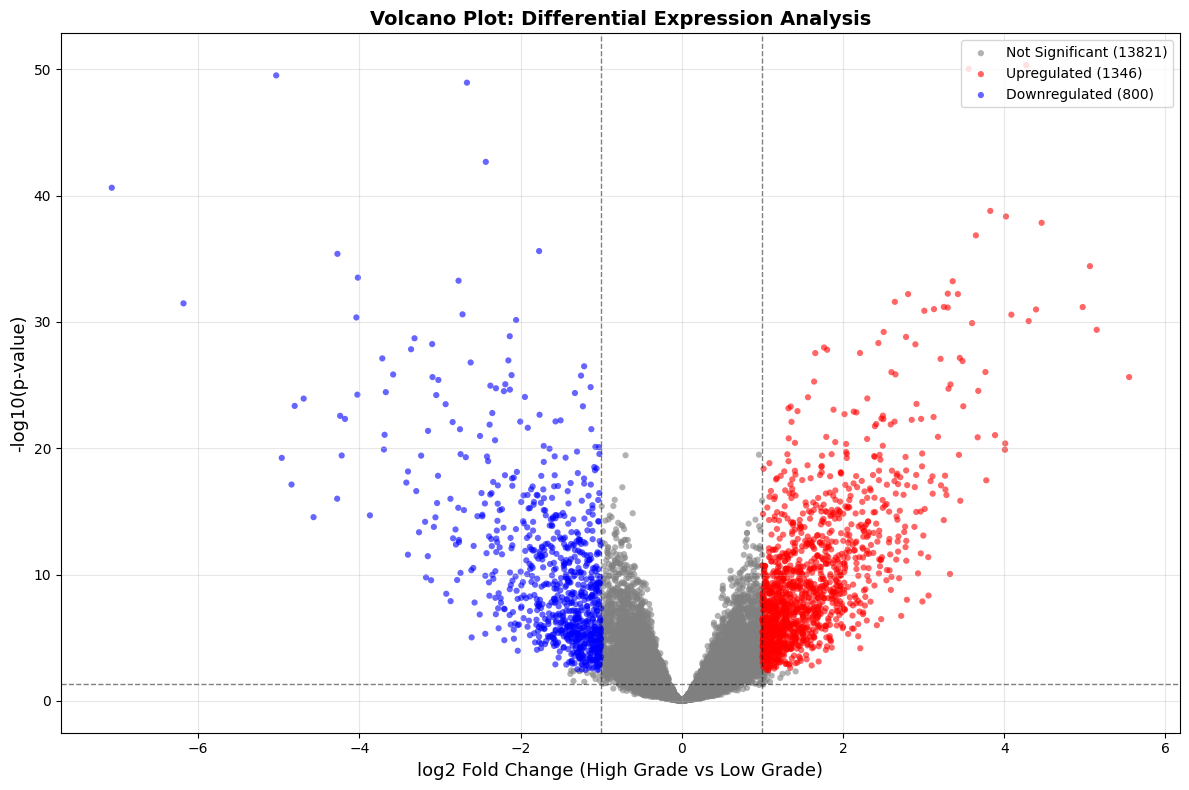

In [35]:
# Volcano plot
deg_results['color'] = 'Not Significant'                                                        # creates a new column called color. Every gene starts labeled as "Not Significant".
deg_results.loc[
    (deg_results['FDR'] < 0.01) & (deg_results['logFC'] > 1), 'color'                           # Mark genes significantly upregulated in High Grade
] = 'Upregulated'
deg_results.loc[
    (deg_results['FDR'] < 0.01) & (deg_results['logFC'] < -1), 'color'
] = 'Downregulated'

fig, ax = plt.subplots(figsize=(12, 8))

colors = {'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'}           # Assign colors for categories

for category, color in colors.items():                                                          # Plot genes category by category (colour)
    mask = deg_results['color'] == category
    ax.scatter(deg_results.loc[mask, 'logFC'],
               -np.log10(deg_results.loc[mask, 'pvalue']),
               c=color, alpha=0.6, s=20,
               label=f'{category} ({mask.sum()})',
               edgecolors='none')

# Threshold lines
ax.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, alpha=0.5)              # Horizontal line = p-value = 0.05, 
ax.axvline(-1, color='black', linestyle='--', linewidth=1, alpha=0.5)                           # Vertical lines = logFC = +1, −1
ax.axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('log2 Fold Change (High Grade vs Low Grade)', fontsize=13)
ax.set_ylabel('-log10(p-value)', fontsize=13)
ax.set_title('Volcano Plot: Differential Expression Analysis', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/task3_volcano_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### We use ALL genes for the volcano plot because the purpose of a volcano plot is to show both significant and non-significant genes; if you used only DEGs, you would lose the gray background points and the volcano plot would no longer be meaningful.
### The volcano plot summarizes the differential expression results between High Grade and Low Grade bladder tumors. 
### Each point represents a gene, where the x-axis shows the log2 fold change and the y-axis shows statistical significance. 
### Red points represent genes that are significantly upregulated in High Grade tumors, while blue points represent genes that are downregulated. Grey points indicate genes with no meaningful difference. T
### The strong separation of red and blue dots suggests many genes change expression between the two tumor grades. 
### The volcano plot shows a large number of genes with high –log10(p-value), meaning they have very low p-values (< 0.05) and are statistically significant.
### Overall, the volcano plot clearly highlights the set of genes most biologically associated with tumor progression.

## Task 3.2
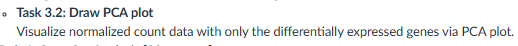


In [36]:
deg_filtered

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSG00000267280.5,376.695515,4.272548,0.284260,15.030421,4.640502e-51,7.409489e-47
ENSG00000121068.14,4290.625532,3.560445,0.237617,14.983980,9.344855e-51,7.460465e-47
ENSG00000092295.12,1257.145068,-5.031445,0.337547,-14.905919,3.016325e-50,1.605389e-46
ENSG00000021355.13,8455.120634,-2.665121,0.179868,-14.817105,1.135741e-49,4.533594e-46
ENSG00000164086.10,3871.779565,-2.431404,0.176016,-13.813516,2.112625e-43,6.746456e-40
...,...,...,...,...,...,...
ENSG00000138944.8,239.726735,1.050221,0.357252,2.939719,3.285103e-03,8.913312e-03
ENSG00000169994.18,129.627261,-1.193799,0.408607,-2.921627,3.482082e-03,9.356849e-03
ENSG00000136542.9,861.476131,-1.048320,0.359606,-2.915187,3.554750e-03,9.524870e-03


### selects only the differentially expressed genes from the full logCPM

In [37]:
# Extract DEGs and subset data
deg_genes = deg_filtered.index.tolist()
deg_cpm = logcpm .loc[deg_genes, :]

print(f"Number of DEGs for PCA: {len(deg_genes)}")
deg_cpm.head() 


Number of DEGs for PCA: 2146


,TCGA-4Z-AA7N-01A-11R-A39I-07,TCGA-K4-A54R-01A-11R-A26T-07,TCGA-DK-A1A3-01A-11R-A13Y-07,TCGA-BL-A0C8-01A-11R-A10U-07,TCGA-UY-A9PD-01A-11R-A38B-07,TCGA-4Z-AA87-01A-11R-A39I-07,TCGA-C4-A0F6-01A-11R-A10U-07,TCGA-BT-A20W-01A-21R-A14Y-07,TCGA-DK-A3IQ-01A-31R-A32Y-07,TCGA-SY-A9G0-01A-12R-A38B-07,...,TCGA-XF-A8HE-01A-11R-A36F-07,TCGA-ZF-A9RD-01A-11R-A42T-07,TCGA-E7-A7XN-01A-11R-A352-07,TCGA-PQ-A6FN-01A-11R-A31N-07,TCGA-BT-A3PK-01A-21R-A220-07,TCGA-GD-A3OQ-01A-32R-A220-07,TCGA-CU-A72E-01A-12R-A33J-07,TCGA-DK-A1AB-01A-11R-A13Y-07,TCGA-FD-A3B7-01A-31R-A20F-07,TCGA-FD-A6TH-01A-11R-A32O-07
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000267280.5,2.453144,3.426396,2.566021,4.695050,5.883973,4.283864,3.632098,4.649780,2.632687,3.104105,...,0.413760,0.699082,0.499378,1.858005,0.789309,1.367355,0.929434,0.290365,0.488292,0.506295
ENSG00000121068.14,6.243828,5.484761,7.538650,7.692660,9.021415,7.483759,6.257182,8.058150,5.971717,6.601349,...,3.294714,3.119269,2.592680,4.869176,5.131626,4.706296,3.475147,3.026501,3.737172,3.719899
ENSG00000092295.12,1.952873,0.848531,2.910983,0.997979,0.876816,0.484223,0.984783,1.884282,0.491406,1.110784,...,6.035951,7.684734,6.666071,6.456296,9.460683,2.650099,2.946200,7.444747,1.308520,0.580598
ENSG00000021355.13,6.528843,6.944712,5.930061,4.809013,5.300158,4.379112,4.350885,5.892181,5.527294,5.692609,...,9.056849,9.457695,9.291451,9.501365,7.964621,7.316580,8.205935,5.885236,7.527751,6.326881
ENSG00000164086.10,5.314942,5.751480,4.490788,4.712951,4.448786,3.087775,4.503234,4.838973,5.045374,4.817124,...,8.155781,6.910881,8.000573,6.853234,8.109615,7.071375,7.679097,6.345493,7.247706,5.898706


In [38]:
sample_labels

array(['Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade', 'Low Grade',
       'High Grade', 'High Grade', 'High Grade', 'High Grade',
       'High Grade', 'High Grade', 'High Grade', 'High Grade',
       'High Grade', 'High Grade', 'High Grade', 'High Grade',
       'High Grade', 'High Grade', 'High Grade', 'High Grade',
       'High Grade', 'High G

### plot PCA

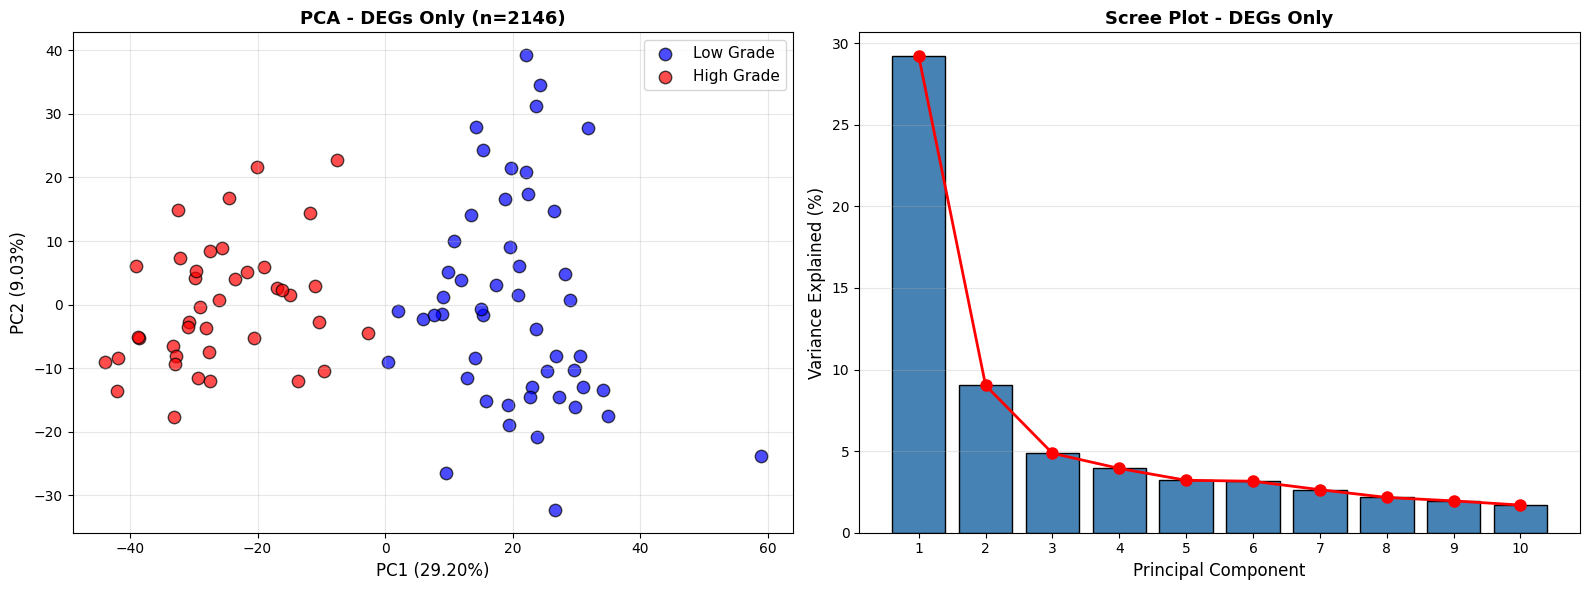


PC1 variance explained (DEGs): 29.20%
PC2 variance explained (DEGs): 9.03%
Cumulative (PC1..PC10): 61.85%


In [39]:
# Perform PCA
pca_input_deg = deg_cpm.T # Transpose
scaler_deg = StandardScaler() # scaling
pca_input_deg_scaled = scaler_deg.fit_transform(pca_input_deg)

pca_deg = PCA(n_components=10)
pca_deg_result = pca_deg.fit_transform(pca_input_deg_scaled)
variance_explained_deg = pca_deg.explained_variance_ratio_ * 100

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCA with DEGs
for grade, color in [('Low Grade', 'blue'), ('High Grade', 'red')]:
    mask = [label == grade for label in sample_labels]
    axes[0].scatter(pca_deg_result[mask, 0], pca_deg_result[mask, 1],
                   c=color, label=grade, s=80, alpha=0.7, edgecolors='black')

axes[0].set_xlabel(f'PC1 ({variance_explained_deg[0]:.2f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({variance_explained_deg[1]:.2f}%)', fontsize=12)
axes[0].set_title(f'PCA - DEGs Only (n={len(deg_genes)})', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Scree plot
axes[1].bar(range(1, 11), variance_explained_deg, color='steelblue', edgecolor='black')
axes[1].plot(range(1, 11), variance_explained_deg, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Principal Component', fontsize=12)
axes[1].set_ylabel('Variance Explained (%)', fontsize=12)
axes[1].set_title('Scree Plot - DEGs Only', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(1, 11))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/task3_pca_degs.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPC1 variance explained (DEGs): {variance_explained_deg[0]:.2f}%")
print(f"PC2 variance explained (DEGs): {variance_explained_deg[1]:.2f}%")
print(f"Cumulative (PC1..PC10): {variance_explained_deg[:11].sum():.2f}%")

### After we identified the significantly differentially expressed genes (DEGs) in Task 3.1, in task 3.2 we have to visualize how well these DEGs separate the two tumor types (Low Grade vs High Grade).
### For this, we performed a Principal Component Analysis (PCA) using only the DEGs, instead of all genes. Because DEGs represent the genes that change the most between the two classes, 
### PCA on DEGs usually produces a clearer separation of the samples. When we plotted PC1 vs PC2, 
## The Low-Grade and High-Grade samples formed more distinct clusters compared to PCA using all genes. 
### This shows that the DEGs capture the main biological differences between the tumor types.
###  PCA on DEGs confirms that the genes we identified truly distinguish Low-Grade from High-Grade bladder cancer.

# Task 4


## 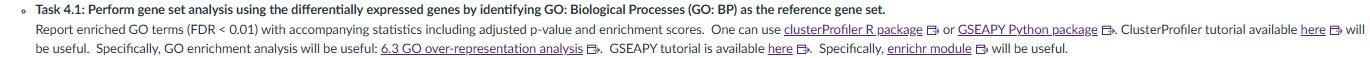

In [40]:
deg_filtered.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSG00000267280.5,376.695515,4.272548,0.284260,15.030421,4.640502e-51,7.409489e-47
ENSG00000121068.14,4290.625532,3.560445,0.237617,14.983980,9.344855e-51,7.460465e-47
ENSG00000092295.12,1257.145068,-5.031445,0.337547,-14.905919,3.016325e-50,1.605389e-46
ENSG00000021355.13,8455.120634,-2.665121,0.179868,-14.817105,1.135741e-49,4.533594e-46
ENSG00000164086.10,3871.779565,-2.431404,0.176016,-13.813516,2.112625e-43,6.746456e-40


In [41]:
gene_annotations.head()

,gene_type,gene_name,hgnc_id
gene_id,,,
ENSG00000000003.15,protein_coding,TSPAN6,HGNC:11858
ENSG00000000005.6,protein_coding,TNMD,HGNC:17757
ENSG00000000419.13,protein_coding,DPM1,HGNC:3005
ENSG00000000457.14,protein_coding,SCYL3,HGNC:19285
ENSG00000000460.17,protein_coding,C1orf112,HGNC:25565


In [42]:
print(deg_filtered.index)

deg_filtered.shape

Index(['ENSG00000267280.5', 'ENSG00000121068.14', 'ENSG00000092295.12',
       'ENSG00000021355.13', 'ENSG00000164086.10', 'ENSG00000124102.5',
       'ENSG00000183248.12', 'ENSG00000095739.11', 'ENSG00000132677.13',
       'ENSG00000117643.14',
       ...
       'ENSG00000107984.10', 'ENSG00000145423.5', 'ENSG00000276085.1',
       'ENSG00000262406.3', 'ENSG00000142623.11', 'ENSG00000138944.8',
       'ENSG00000169994.18', 'ENSG00000136542.9', 'ENSG00000125869.10',
       'ENSG00000152315.5'],
      dtype='object', name='gene_id', length=2146)


(2146, 6)

### Prepare DEGs with gene symbols

In [43]:

deg_filtered2 = deg_filtered.copy()

#  REMOVE VERSION NUMBER
def strip_version(gid):
    return gid.split(".")[0]

deg_filtered2["ensembl_id"] = deg_filtered2.index.to_series().apply(strip_version)

gene_annot2 = gene_annotations.copy()
gene_annot2["ensembl_id"] = gene_annot2.index.to_series().apply(strip_version)

# CREATE MAPPING (Ensembl → Gene Symbol)
mapping = gene_annot2.set_index("ensembl_id")["gene_name"].to_dict()

# 4. MAP SYMBOLS TO DEGs
deg_filtered2["gene_symbol"] = deg_filtered2["ensembl_id"].map(mapping)

# Remove unmapped genes
deg_filtered_with_symbols = deg_filtered2.dropna(subset=["gene_symbol"])

print("DEGs with gene symbols:", deg_filtered_with_symbols.shape[0])
print(deg_filtered_with_symbols[["gene_symbol", "log2FoldChange", "padj"]].head())

# Save
deg_filtered_with_symbols.to_csv("results/task4_deg_with_symbols.csv")


DEGs with gene symbols: 2146
                   gene_symbol  log2FoldChange          padj
gene_id                                                     
ENSG00000267280.5     TBX2-AS1        4.272548  7.409489e-47
ENSG00000121068.14        TBX2        3.560445  7.460465e-47
ENSG00000092295.12        TGM1       -5.031445  1.605389e-46
ENSG00000021355.13    SERPINB1       -2.665121  4.533594e-46
ENSG00000164086.10       DUSP7       -2.431404  6.746456e-40


### Run GO Biological Process Enrichment (Top 20)

In [ ]:
def perform_go_bp_enrichment(deg_df):
    # Use gene symbols
    gene_list = deg_df["gene_symbol"].dropna().tolist()

    print(f"Running Enrichr on {len(gene_list)} genes...")

    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets="GO_Biological_Process_2023",
        organism="human",
        outdir=None,
        no_plot=True
    )

    results = enr.results
    sig = results[results["Adjusted P-value"] < 0.05]       # GSEApy/Enrichr is already sorted by "Adjusted P-value" ascending by default
    sig["Genes"] = sig["Genes"].astype(str)

    return sig


# Run GO Biological Process enrichment
go_bp_results = perform_go_bp_enrichment(deg_filtered_with_symbols)

# Save
go_bp_results.to_csv("results/task4_go_bp_results.csv", index=False)

# Print TOP 20 like friend
print("\nTop 20 Enriched GO Biological Processes:")
print("="*60)
top20 = go_bp_results.head(20)[["Term", "Adjusted P-value", "Overlap", "Combined Score", "Genes"]]
print(top20)


Running Enrichr on 2146 genes...

Top 20 Enriched GO Biological Processes:
                                                 Term  Adjusted P-value  \
0   Regulation Of Cell Population Proliferation (G...      2.885282e-07   
1           Regulation Of Cell Migration (GO:0030334)      1.079038e-05   
2   Negative Regulation Of Cell Population Prolife...      1.079038e-05   
3   Negative Regulation Of Cellular Process (GO:00...      1.079038e-05   
4   Positive Regulation Of Cell Motility (GO:2000147)      1.079038e-05   
5         Response To Type II Interferon (GO:0034341)      2.064247e-05   
6   Positive Regulation Of Cell Population Prolife...      6.814857e-05   
7   Cellular Response To Type II Interferon (GO:00...      8.291608e-05   
8                 Granulocyte Chemotaxis (GO:0071621)      1.392067e-04   
9                  Neutrophil Chemotaxis (GO:0030593)      2.227642e-04   
10            Regulation Of Angiogenesis (GO:0045765)      3.377788e-04   
11  Positive Regulation O

/var/folders/gp/j3rnm9qn6pzf3bwygfrrd5cm0000gq/T/ipykernel_18351/1258106507.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig["Genes"] = sig["Genes"].astype(str)


## Top genes for Biological process whole enrichment list

In [52]:
import pandas as pd
from collections import Counter

# Your results dataframe
df = go_bp_results.copy()

# If gene list is in a column named "Genes" or "Gene_set", adapt this:
# We assume the column is "Genes" or the last column with gene symbols
gene_col = df.columns[-1]

# Extract and count frequencies
gene_counts = Counter()

for genes in df[gene_col]:
    if isinstance(genes, str):
        gene_list = genes.split(";")         # split at ';'
        gene_list = [g.strip() for g in gene_list]
        gene_counts.update(gene_list)

# Convert to DataFrame
dominant_genes = (pd.DataFrame.from_dict(gene_counts, orient='index', columns=['Frequency'])
                  .sort_values('Frequency', ascending=False))

print("\nTop Dominant Genes Across Enriched GO Terms:")
print(dominant_genes.head(20))

# Save
dominant_genes.to_csv("results/task4_dominant_genes.csv")



Top Dominant Genes Across Enriched GO Terms:
        Frequency
TGFB1          49
BMP4           41
BMP2           38
TGFB2          35
SOX9           34
DAB2IP         33
CX3CL1         32
CCL3           30
SFRP1          30
CCL19          29
PPARG          26
NRG1           25
GATA3          23
SFRP2          23
MEF2C          23
CXCL8          20
FGFR2          20
CCL24          19
AGT            19
EGFR           19


### We took filtered  DEGs from Task 3 to check what biological functions or pathways these genes belong to.
### This helps us understand which biological processes are active or disrupted in High-Grade vs Low-Grade cancer, such as cell cycle, immune response, or metabolism.

### DEGs alone don’t tell us the biology, we used GO Enrichment Analysis to see which biological processes are statistically over-represented among those genes. 
### We first mapped Ensembl IDs to gene symbols, then used the Enrichr (GSEApy) tool to test whether the DEGs are enriched for known Gene Ontology Biological Processes. 
### The analysis identified many significant pathways such as cell proliferation, wound healing, angiogenesis, immune response, and cell migration, which are all biologically relevant to cancer progression. 
### in other words, the output shows which biological process are over-represented (enriched) amomg differentially expresed gene (DEGs).In the table "Term" tell us which biological process are altered, FDR < 0.05 means more genes are involved in this GO term than expected. "overlap  141/766 " means DEG list contains 141 genes linked to this process. The GO category contains 766 known genes. Larger numerator = more of your genes participate in that process.Combined score value helps to compare strong enrichment

### After running GO enrichment, you get a long list of enriched GO terms like: regulation of cell proliferation, inflammatory response etc..
### This list itself is not the interpretation, for that we need to Look at which biological processes are enriched

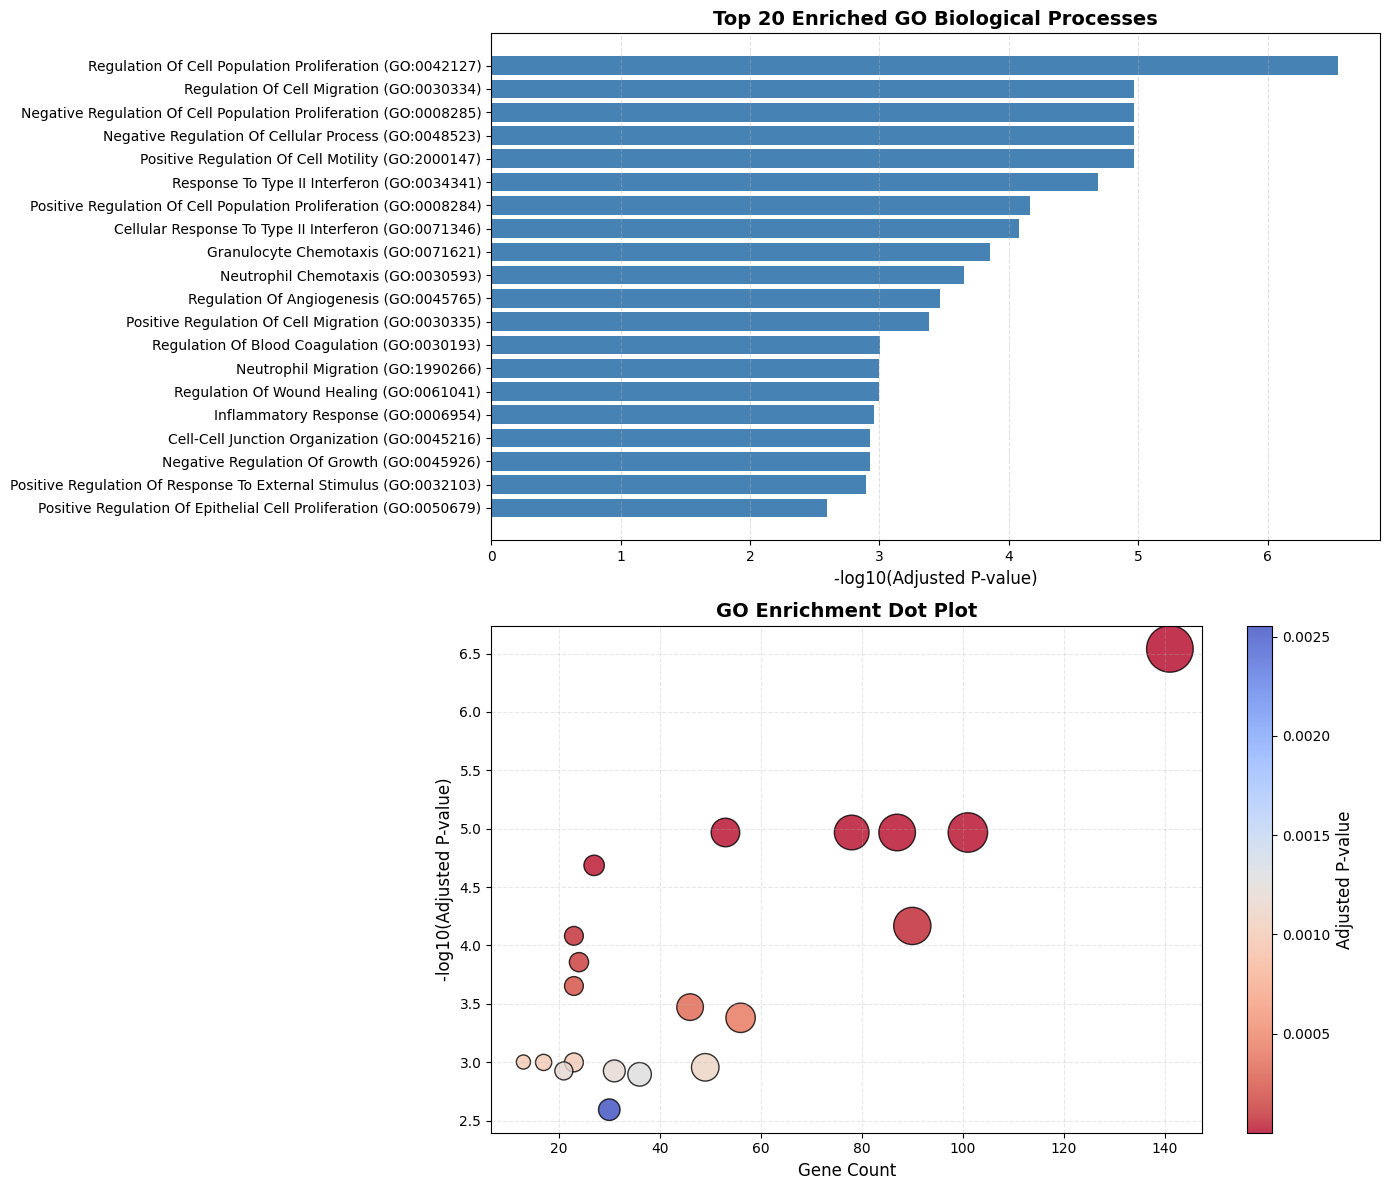

In [45]:

# 1. Take TOP 20 GO terms

top20 = go_bp_results.head(20).copy()

# Convert adjusted p-values to -log10 scale
top20["neg_log10_padj"] = -np.log10(top20["Adjusted P-value"])

# Extract gene count from "Overlap" column (format: 45/766)
top20["Gene Count"] = top20["Overlap"].apply(lambda x: int(x.split("/")[0]))


# 2. FIGURE WITH TWO PLOTS

fig = plt.figure(figsize=(14, 12))


# PLOT 1 — HORIZONTAL BAR PLOT OF TOP 20 GO TERMS

ax1 = fig.add_subplot(2, 1, 1)

ax1.barh(top20["Term"], top20["neg_log10_padj"], color="steelblue")
ax1.set_xlabel("-log10(Adjusted P-value)", fontsize=12)
ax1.set_title("Top 20 Enriched GO Biological Processes", fontsize=14, fontweight="bold")
ax1.invert_yaxis()   # Highest enrichment at top

# Add grid
ax1.grid(True, axis="x", linestyle="--", alpha=0.4)

# PLOT 2 — DOT PLOT

ax2 = fig.add_subplot(2, 1, 2)

scatter = ax2.scatter(
    top20["Gene Count"], 
    top20["neg_log10_padj"],
    s=top20["Gene Count"]*8,      # Bubble size
    c=top20["Adjusted P-value"],  # Color by p-value
    cmap="coolwarm_r",
    alpha=0.8,
    edgecolors="black"
)

ax2.set_xlabel("Gene Count", fontsize=12)
ax2.set_ylabel("-log10(Adjusted P-value)", fontsize=12)
ax2.set_title("GO Enrichment Dot Plot", fontsize=14, fontweight="bold")

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Adjusted P-value", fontsize=12)

# Grid
ax2.grid(True, linestyle="--", alpha=0.3)


# FINAL: SAVE & SHOW

plt.tight_layout()
plt.savefig("results/task4_go_enrichment_plots.png", dpi=300, bbox_inches='tight')
plt.show()


### The GO (Gene Ontology) enrichment analysis revealed that the differentially expressed genes are strongly associated with key cancer-related biological processes. The top enriched terms involve cell proliferation, cell migration, angiogenesis, wound healing, chemotaxis, and immune response



## Biological Interpretion

In [46]:
# ============================================================
# BIOLOGICAL INTERPRETATION OF GO TERMS – BLADDER CANCER CONTEXT
# ============================================================

def print_section(title, terms):
    print(f"\n{title}:")
    print("-" * 70)
    if len(terms) == 0:
        print("No significant terms found")
        return
    for _, row in terms.iterrows():
        term = row["Term"]
        fdr = row["Adjusted P-value"]
        overlap = row["Overlap"]
        print(f"- {term}")
        print(f"  FDR: {fdr:.2E} | Genes: {overlap}")

# -------------------------------
# 1. GROUP GO TERMS INTO THEMES
# -------------------------------

cell_proliferation_terms = go_bp_results[
    go_bp_results["Term"].str.contains("Proliferation", case=False)
]

immune_response_terms = go_bp_results[
    go_bp_results["Term"].str.contains("immune|cytokine|leukocyte|inflammatory", case=False)
]

emt_invasion_terms = go_bp_results[
    go_bp_results["Term"].str.contains("migration|motility|epithelial", case=False)
]

metabolism_terms = go_bp_results[
    go_bp_results["Term"].str.contains("biosynthetic|metabolic|lipid", case=False)
]

angiogenesis_terms = go_bp_results[
    go_bp_results["Term"].str.contains("angiogenesis|endothelial", case=False)
]

apoptosis_terms = go_bp_results[
    go_bp_results["Term"].str.contains("apoptosis", case=False)
]

dna_damage_terms = go_bp_results[
    go_bp_results["Term"].str.contains("DNA|damage|repair", case=False)
]

# -------------------------------
# 2. PRINT FINAL INTERPRETATION
# -------------------------------
print("============================================================")
print("BIOLOGICAL INTERPRETATION: GO TERMS IN BLADDER CANCER CONTEXT")
print("============================================================")

print_section("Cell Proliferation", cell_proliferation_terms)
print_section("Immune Response", immune_response_terms)
print_section("EMT & Invasion", emt_invasion_terms)
print_section("Metabolism", metabolism_terms)
print_section("Angiogenesis", angiogenesis_terms)
print_section("Apoptosis", apoptosis_terms)
print_section("DNA Damage", dna_damage_terms)


BIOLOGICAL INTERPRETATION: GO TERMS IN BLADDER CANCER CONTEXT

Cell Proliferation:
----------------------------------------------------------------------
- Regulation Of Cell Population Proliferation (GO:0042127)
  FDR: 2.89E-07 | Genes: 141/766
- Negative Regulation Of Cell Population Proliferation (GO:0008285)
  FDR: 1.08E-05 | Genes: 78/379
- Positive Regulation Of Cell Population Proliferation (GO:0008284)
  FDR: 6.81E-05 | Genes: 90/483
- Positive Regulation Of Epithelial Cell Proliferation (GO:0050679)
  FDR: 2.55E-03 | Genes: 30/123
- Negative Regulation Of Epithelial Cell Proliferation (GO:0050680)
  FDR: 9.90E-03 | Genes: 19/70
- Regulation Of T Cell Proliferation (GO:0042129)
  FDR: 1.05E-02 | Genes: 20/77
- Negative Regulation Of Lymphocyte Proliferation (GO:0050672)
  FDR: 1.05E-02 | Genes: 13/39
- Regulation Of Epithelial Cell Proliferation (GO:0050678)
  FDR: 1.29E-02 | Genes: 22/91
- Positive Regulation Of Lymphocyte Proliferation (GO:0050671)
  FDR: 1.37E-02 | Genes: 19

### We obtained 153 significant GO biological processes.
### To make interpretation easier, we assigned GO terms into broad biological categories such as cell proliferation, immune response, EMT/invasion, metabolism and angiogenesis.
### This helps summarize the major biological mechanisms enriched in the differentially expressed genes.

## Summay and export

In [47]:

# ===========================
# CREATE ANALYSIS SUMMARY
# ===========================

summary = {
    "Total Samples": metadata.shape[0],
    "Low Grade Samples": (metadata["tumor_type"] == "Low Grade").sum(),
    "High Grade Samples": (metadata["tumor_type"] == "High Grade").sum(),
    "Genes After Filtering": filtered_counts.shape[0],
    "Optimal Clusters (K-mean cluster)": 2,
    "Total DEGs (FDR<0.01, |log2FC|>1)": deg_filtered.shape[0],
    "Upregulated DEGs": (deg_filtered["log2FoldChange"] > 1).sum(),
    "Downregulated DEGs": (deg_filtered["log2FoldChange"] < -1).sum(),
    "DEGs with Gene Symbols": deg_filtered_with_symbols.shape[0],
    "Enriched GO:BP Terms (FDR<0.05)": go_bp_results.shape[0]
}

# Convert to DataFrame 
summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
summary_df.to_csv("results/analysis_summary.csv", index=False)

# ===========================
# PRINT REPORT
# ===========================

print("\n" + "="*70)
print("ANALYSIS SUMMARY")
print("="*70)

for metric, value in summary.items():
    print(f"{metric}: {value}")

print("="*70)
print("\nAnalysis complete. Results saved to results/ directory.\n")



ANALYSIS SUMMARY
Total Samples: 90
Low Grade Samples: 50
High Grade Samples: 40
Genes After Filtering: 15967
Optimal Clusters (K-mean cluster): 2
Total DEGs (FDR<0.01, |log2FC|>1): 2146
Upregulated DEGs: 1346
Downregulated DEGs: 800
DEGs with Gene Symbols: 2146
Enriched GO:BP Terms (FDR<0.05): 153

Analysis complete. Results saved to results/ directory.



### References 
#### Robertson, A. G., Kim, J., Al-Ahmadie, H., Bellmunt, J., Guo, G., Cherniack, A. D., ... & Tam, A. (2017). Comprehensive molecular characterization of muscle-invasive bladder cancer. Cell, 171(3), 540-556.